In [1]:
import pandas as pd
import numpy as np
import os
import json
from tqdm import tqdm

# full_data = pd.DataFrame()
# for folder in tqdm(os.listdir()):
#     # check if folder is a directory
#     if not os.path.isdir(folder):
#         continue
#     # load params.json from each folder
#     with open(os.path.join(folder, 'params.json')) as f:
#         params = json.load(f)
#     # load data from each folder
#     try:
#         data = pd.read_csv(os.path.join(folder, 'results.csv.gz'), compression='gzip')
#     except FileNotFoundError:
#         continue
#     # att remaining params to data
#     keys = [i for i in params.keys() if i not in ['save_path', 'action_set_data', 'reward_set_data','n_ensemble','print_every']]
#     for key in keys:
#         if key == 'hidden_state_sizes':
#             data[key] = 'x'.join(map(str, params[key]))
#         else:
#             data[key] = params[key]
#     # append to full_data
#     full_data = pd.concat([full_data, data], ignore_index=Tru

full_data = pd.read_pickle('../../../modelfits/nn/full_data.pkl')

In [2]:
# save to compressed dataframe
full_data.to_pickle('full_data.pkl')

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

In [4]:
full_data.columns

Index(['ModelID', 'EnsembleID', 'FoldID', 'FlyID', 'MSE(train)', 'NMSE(train)',
       'LogLikelihood(train)', 'AIC(train)', 'BIC(train)', 'MSE(test)',
       'NMSE(test)', 'LogLikelihood(test)', 'AIC(test)', 'BIC(test)',
       'P(action)', 'Model Path', 'Training Loss', 'Validation Loss',
       'Best Validation Loss', 'Epochs', 'Best Validation Epoch',
       'Training Time', 'agent', 'n_folds', 'history_size', 'max_epochs',
       'early_stopping', 'learning_rate', 'weight_decay', 'train_test_split',
       'reservoir_size', 'num_reservoirs', 'encoder_size', 'kind',
       'hidden_state_sizes', 'activation', 'policy_type', 'device',
       'symmetric', 'allow_negative', 'omission_is_punishment'],
      dtype='object')

c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


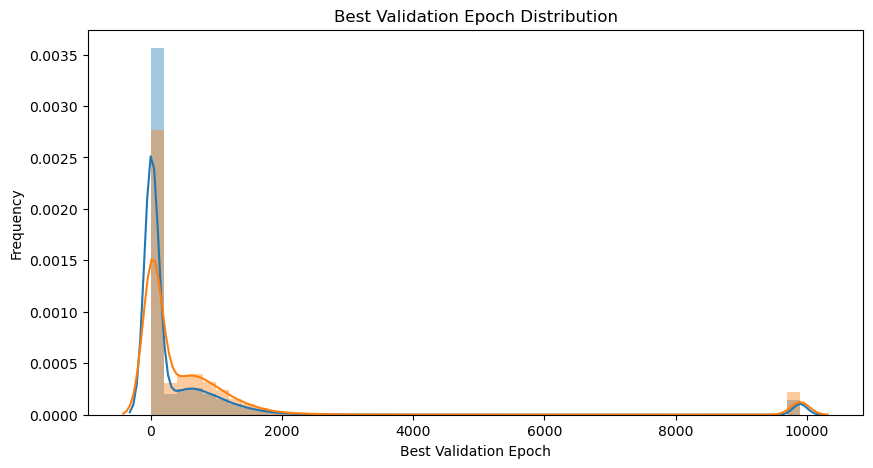

In [5]:
# plot a histogram of the best validation epochs
fig, ax = plt.subplots(figsize=(10,5))
sns.distplot(full_data['Best Validation Epoch'], ax=ax)

# backup full_data
full_data_backup = full_data.copy()

# filter out the data that had the first epoch as the best validation epoch
full_data = full_data[full_data['Best Validation Epoch'] != 0]

sns.distplot(full_data['Best Validation Epoch'], ax=ax)
ax.set_xlabel('Best Validation Epoch')
ax.set_ylabel('Frequency')
ax.set_title('Best Validation Epoch Distribution')
plt.show()

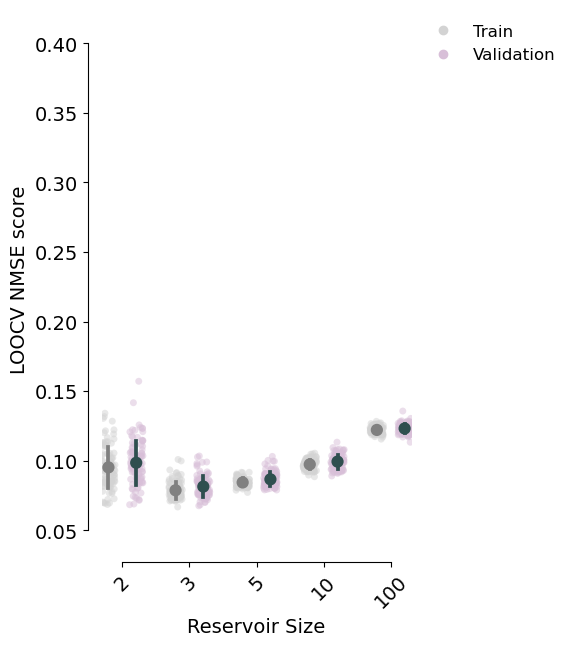

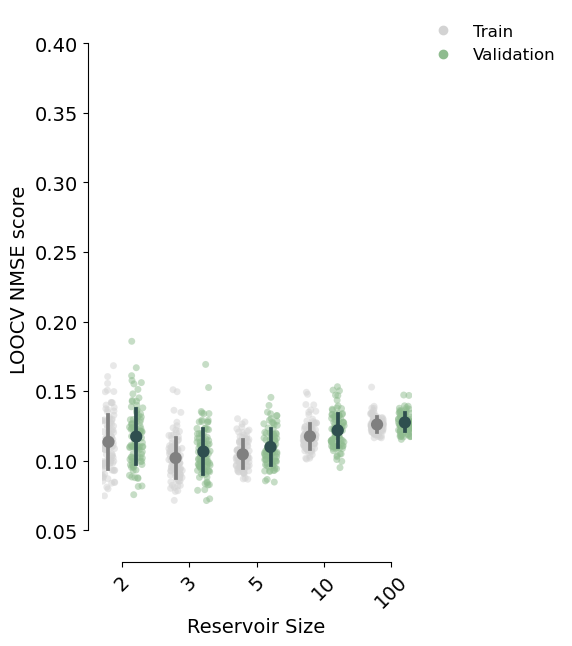

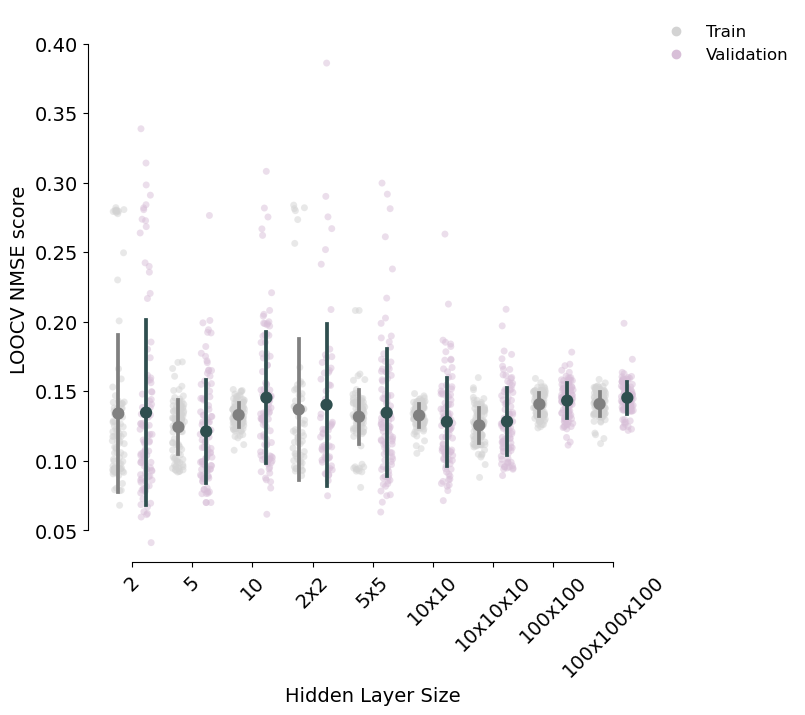

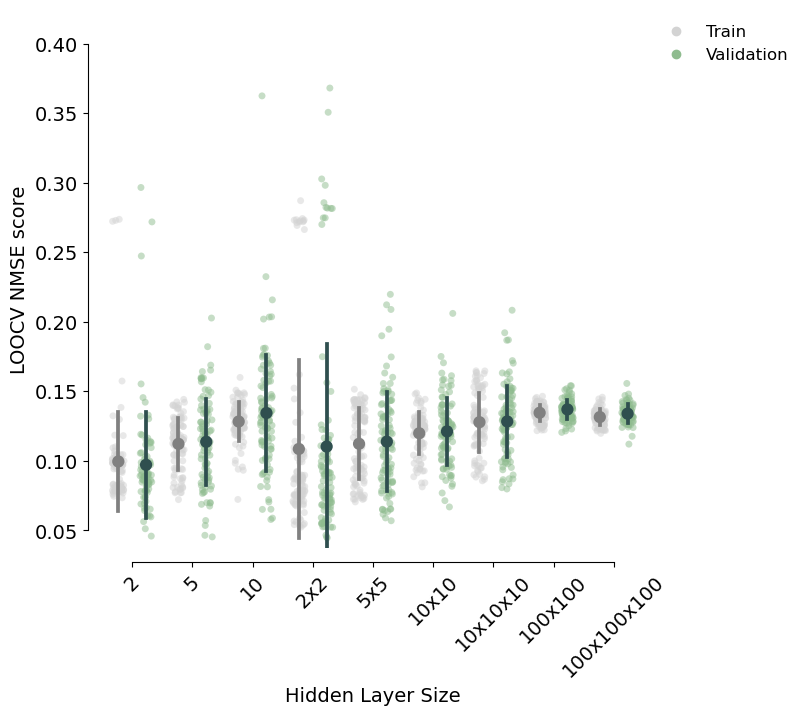

In [6]:
metric = "NMSE" # "MSE" or "NMSE" or "LogLikelihood" or "AIC" or "BIC"

reduced_data = full_data.groupby(['ModelID','EnsembleID']).mean().reset_index()

# find the minimum value of the metric
min_val = min(reduced_data[f"{metric}(train)"].min(), reduced_data[f"{metric}(test)"].min())
# find the maximum value of the metric
max_val = max(reduced_data[f"{metric}(train)"].max(), reduced_data[f"{metric}(test)"].max())

for agent in ["GRNN", "GQNN"]:
    for sym in [True,False]:
        # set fontsize
        plt.rcParams.update({'font.size': 14})

        sub_df = full_data[full_data['agent'] == agent]
        sub_df = sub_df[sub_df['symmetric'] == sym]
        sub_df = sub_df.groupby(['ModelID','EnsembleID']).agg({'{}(train)'.format(metric):'mean', '{}(test)'.format(metric):'mean', 'reservoir_size':lambda x: x.iloc[0], 'hidden_state_sizes':lambda x: x.iloc[0]}).reset_index()

        fig, ax = plt.subplots(figsize=(4,7) if agent == "GRNN" else (7,7))

        var = "hidden_state_sizes" if agent == "GQNN" else "reservoir_size"
        order = [2,3,5,10,100] if agent == "GRNN" else ['2','5','10','2x2','5x5','10x10','10x10x10','100x100','100x100x100']

        # plot training error
        sns.stripplot(x=var, y=f'{metric}(train)', data=sub_df, dodge=True, jitter=True, color='lightgrey', ax=ax, size=5, alpha=0.5, order=order)
        plt.setp(ax.lines, zorder=-100)
        plt.setp(ax.collections, zorder=-100, label="")
        sns.pointplot(x=var, y=f'{metric}(train)', data=sub_df, dodge=True, join=False, ci='sd',color='grey', ax=ax, order=order)
        offset = transforms.ScaledTranslation(-20/72, 0, fig.dpi_scale_trans)
        for i in ax.collections:
            trans = i.get_transform()
            i.set_transform(trans + offset)
        for i in ax.lines:
            trans = i.get_transform()
            i.set_transform(trans + offset)

        # plot testing error
        color = "thistle" if sym else "darkseagreen"
        sns.stripplot(x=var, y=f'{metric}(test)', data=sub_df, dodge=True, jitter=True, color=color, ax=ax, size=5, alpha=0.5, order= order)
        plt.setp(ax.lines, zorder=-100)
        plt.setp(ax.collections, zorder=-100, label="")
        sns.pointplot(x=var, y=f'{metric}(test)', data=sub_df, dodge=True, join=False, ci='sd',color='darKslategray', ax=ax, order=order)
        offset = transforms.ScaledTranslation(10/72, 0, fig.dpi_scale_trans)
        for i in ax.collections:
            trans = i.get_transform()
            i.set_transform(trans + offset)
        for i in ax.lines:
            trans = i.get_transform()
            i.set_transform(trans + offset)


        # set axis properties
        ax.set_ylim(0.9*min_val, 1.1*max_val)
        # remove top and right spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        # make left and bottom spines invisible
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        # create empty markers for legend
        ax.plot([], [], 'o', color='lightgrey', label="Train")
        ax.plot([], [], 'o', color=color, label="Validation")
        legend = ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=12)
        # remove legend frame
        legend.set_frame_on(False)
        # set x-axis and y-axis labels
        ax.set_xlabel("Reservoir Size" if agent == "GRNN" else "Hidden Layer Size", fontsize=14)
        ax.set_ylabel(f"LOOCV {metric} score")
        # despine
        sns.despine(offset=10, trim=True);
        # rotate x-axis labels
        plt.setp(ax.get_xticklabels(), rotation=45)

        # save as vector graphic
        plt.savefig(f"../figures/NN-analysis/{agent}_{metric}_{'symmetric' if sym else 'asymmetric'}_full_version.pdf", bbox_inches='tight')
        plt.show()


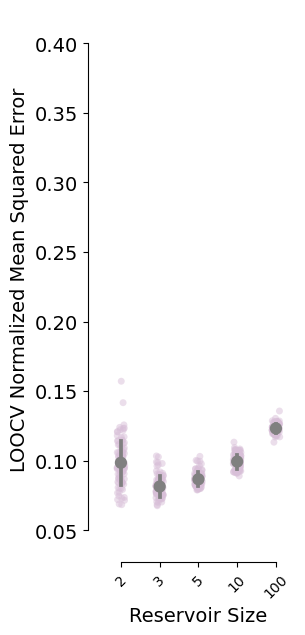

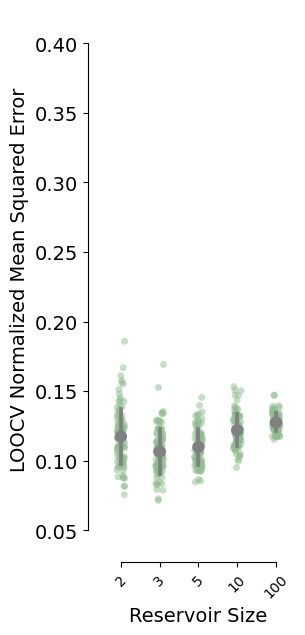

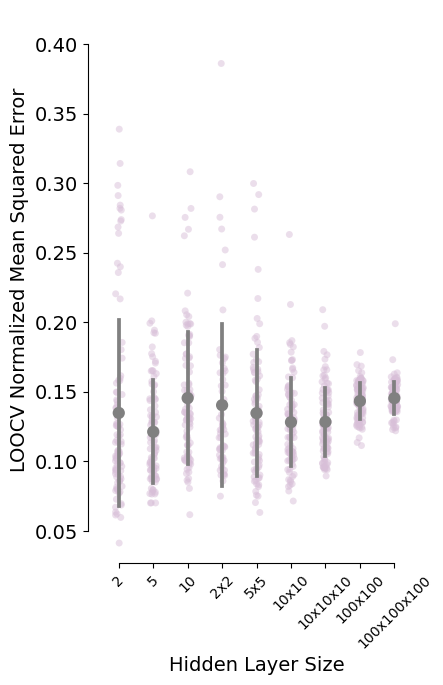

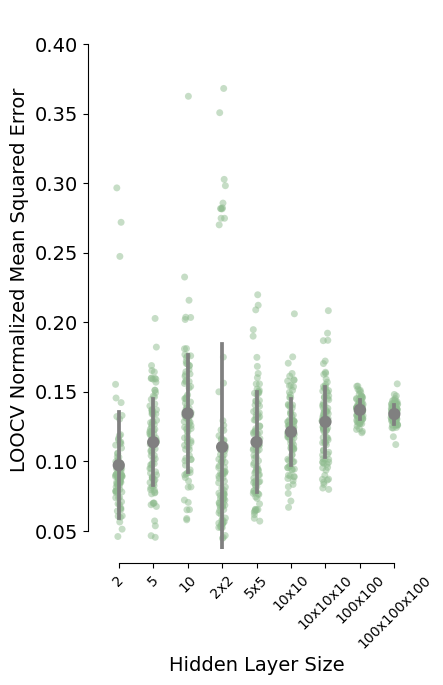

In [7]:
metric = "NMSE" # "MSE" or "NMSE" or "LogLikelihood" or "AIC" or "BIC"
metric_map = {"MSE":"Mean Squared Error", "NMSE":"Normalized Mean Squared Error", "LogLikelihood":"Log Likelihood", "AIC":"Akaike Information Criterion", "BIC":"Bayesian Information Criterion"}
reduced_data = full_data.groupby(['ModelID','EnsembleID']).mean().reset_index()

# find the minimum value of the metric
min_val = min(reduced_data[f"{metric}(train)"].min(), reduced_data[f"{metric}(test)"].min())
# find the maximum value of the metric
max_val = max(reduced_data[f"{metric}(train)"].max(), reduced_data[f"{metric}(test)"].max())

for agent in ["GRNN", "GQNN"]:
    for sym in [True,False]:
        # set fontsize
        plt.rcParams.update({'font.size': 14})

        sub_df = full_data[full_data['agent'] == agent]
        sub_df = sub_df[sub_df['symmetric'] == sym]
        sub_df = sub_df.groupby(['ModelID','EnsembleID']).agg({'{}(train)'.format(metric):'mean', '{}(test)'.format(metric):'mean', 'reservoir_size':lambda x: x.iloc[0], 'hidden_state_sizes':lambda x: x.iloc[0]}).reset_index()

        fig, ax = plt.subplots(figsize=(2.5,7) if agent == "GRNN" else (4,7))

        var = "hidden_state_sizes" if agent == "GQNN" else "reservoir_size"
        order = [2,3,5,10,100] if agent == "GRNN" else ['2','5','10','2x2','5x5','10x10','10x10x10','100x100','100x100x100']

        # plot training error
        color = "thistle" if sym else "darkseagreen"
        sns.stripplot(x=var, y=f'{metric}(test)', data=sub_df, dodge=True, jitter=True, color=color, ax=ax, size=5, alpha=0.5, order=order)
        plt.setp(ax.lines, zorder=-100)
        plt.setp(ax.collections, zorder=-100, label="")
        sns.pointplot(x=var, y=f'{metric}(test)', data=sub_df, dodge=True, join=False, ci='sd',color='grey', ax=ax, order=order)


        # set axis properties
        ax.set_ylim(0.9*min_val, 1.1*max_val)
        # remove top and right spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        # make left and bottom spines invisible
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        # set x-axis and y-axis labels
        ax.set_xlabel("Reservoir Size" if agent == "GRNN" else "Hidden Layer Size", fontsize=14)
        ax.set_ylabel(f"LOOCV {metric_map[metric]}")
        # despine
        sns.despine(offset=10, trim=True);
        # rotate x-axis labels
        plt.setp(ax.get_xticklabels(), rotation=45)
        # reduce fontsize of x-axis labels
        plt.setp(ax.get_xticklabels(), fontsize=10)

        # save as vector graphic
        plt.savefig(f"../figures/NN-analysis/{agent}_{metric}_{'symmetric' if sym else 'asymmetric'}_full_version.pdf", bbox_inches='tight')
        plt.show()


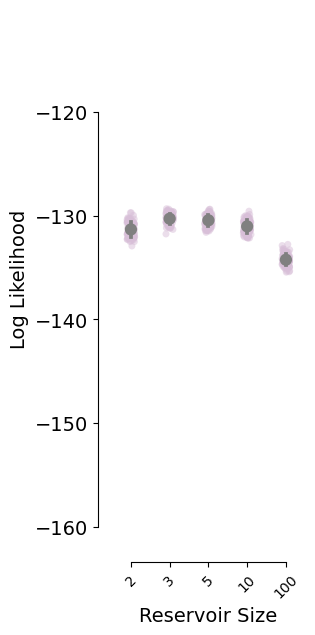

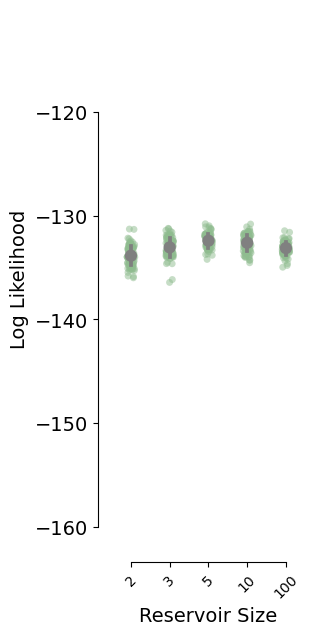

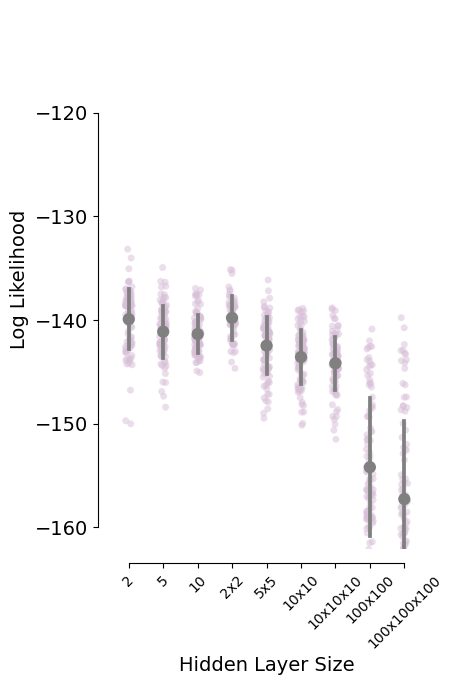

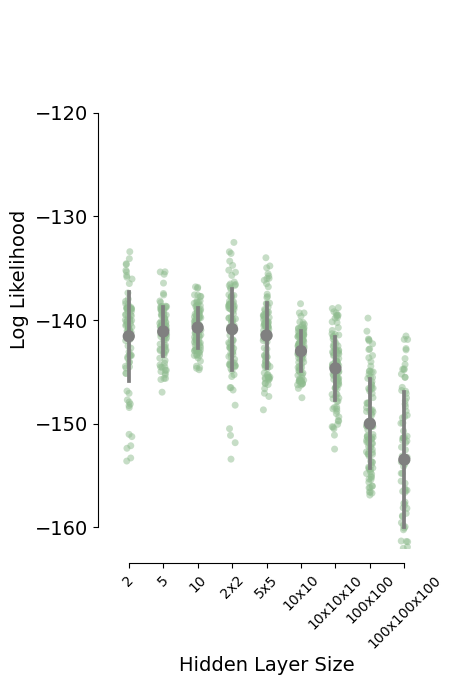

In [8]:
metric = "LogLikelihood" # "MSE" or "NMSE" or "LogLikelihood" or "AIC" or "BIC"
metric_map = {"MSE":"Mean Squared Error", "NMSE":"Normalized Mean Squared Error", "LogLikelihood":"Log Likelihood", "AIC":"Akaike Information Criterion", "BIC":"Bayesian Information Criterion"}
reduced_data = full_data.groupby(['ModelID','EnsembleID']).mean().reset_index()

# find the minimum value of the metric
min_val = min(reduced_data[f"{metric}(train)"].min(), reduced_data[f"{metric}(test)"].min())
# find the maximum value of the metric
max_val = max(reduced_data[f"{metric}(train)"].max(), reduced_data[f"{metric}(test)"].max())

for agent in ["GRNN", "GQNN"]:
    for sym in [True,False]:
        # set fontsize
        plt.rcParams.update({'font.size': 14})

        sub_df = full_data[full_data['agent'] == agent]
        sub_df = sub_df[sub_df['symmetric'] == sym]
        sub_df = sub_df.groupby(['ModelID','EnsembleID']).agg({'{}(train)'.format(metric):'mean', '{}(test)'.format(metric):'mean', 'reservoir_size':lambda x: x.iloc[0], 'hidden_state_sizes':lambda x: x.iloc[0]}).reset_index()

        fig, ax = plt.subplots(figsize=(2.5,7) if agent == "GRNN" else (4,7))

        var = "hidden_state_sizes" if agent == "GQNN" else "reservoir_size"
        order = [2,3,5,10,100] if agent == "GRNN" else ['2','5','10','2x2','5x5','10x10','10x10x10','100x100','100x100x100']

        # plot training error
        color = "thistle" if sym else "darkseagreen"
        sns.stripplot(x=var, y=f'{metric}(train)', data=sub_df, dodge=True, jitter=True, color=color, ax=ax, size=5, alpha=0.5, order=order)
        plt.setp(ax.lines, zorder=-100)
        plt.setp(ax.collections, zorder=-100, label="")
        sns.pointplot(x=var, y=f'{metric}(train)', data=sub_df, dodge=True, join=False, ci='sd',color='grey', ax=ax, order=order)


        # set axis properties
        ax.set_ylim(0.9*min_val, 1.1*max_val)
        # remove top and right spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        # make left and bottom spines invisible
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        # set x-axis and y-axis labels
        ax.set_xlabel("Reservoir Size" if agent == "GRNN" else "Hidden Layer Size", fontsize=14)
        ax.set_ylabel(f"{metric_map[metric]}")
        # despine
        sns.despine(offset=10, trim=True);
        # rotate x-axis labels
        plt.setp(ax.get_xticklabels(), rotation=45)
        # reduce fontsize of x-axis labels
        plt.setp(ax.get_xticklabels(), fontsize=10)

        # save as vector graphic
        plt.savefig(f"../figures/NN-analysis/{agent}_{metric}_{'symmetric' if sym else 'asymmetric'}.pdf", bbox_inches='tight')
        plt.show()


In [9]:
from flymazerl.agents.neuralnetworks import GQLearner, GRNNLearner
from flymazerl.gym.environment import ymaze_static


index = 0

entry = full_data.iloc[index]
model_id = entry['ModelID']
model_type = entry['agent']
path = entry['Model Path']
model_path = f"../../../nn/{model_id}/{path}.pt"

env = ymaze_static(100, 0.5)

# create learner parameters
learner_params = {
    "allow_negative_values": True,
    "symmetric_q_function": entry['symmetric'],
    "omission_is_punishment": False,
    "policy_type": 'acceptreject',
    "device": 'cpu',
    "pre_trained": False,
    "model_path": None,
    "multi_agent": False,
    "n_agents": 1,
}
if entry.agent == "GQNN":
    learner_params["hidden_state_sizes"] = [int(x) for x in entry.hidden_state_sizes.split('x')]
    learner_params["activation"] = "relu"
    learner = GQLearner(env,learner_params)
elif entry.agent == "GRNN":
    learner_params["encoder_size"] = None
    learner_params["num_layers"] = 1
    learner_params["reservoir_size"] = int(entry.reservoir_size)
    learner_params["kind"] = 'RNN'
    learner = GRNNLearner(env, learner_params)

learner.next_episode()


WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [11]:
learner.action_history

array([0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 1.,
       1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 1., 1.,
       1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1.])

In [37]:
for i in 10000:
    entry =[int(x) for x in entry.hidden_state_sizes.split('x')]

array(['5', '2x2', '10x10x10', '10', '2', '5x5', '100x100', '10x10',
       '100x100x100'], dtype=object)